In [1]:
#!pip install kaleido

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Outputs

/content/drive/MyDrive/Outputs


In [4]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import cv2
import datetime
from math import radians, cos, sin, asin, sqrt

import warnings
warnings.filterwarnings('ignore')

In [5]:
def get_undistorted_endpoints(mu, S, H, W, x, y):
    cx = (W-1)/2        # image center coordinate [pixel]
    cy = (H-1)/2        # image center coordinate [pixel]

    K = np.array([[f/mu,0,cx],[0,f/mu,cy],[0,0,1]])

    # compute intrinsic matrix for ouput image
    cpx = (W*S-1)/2
    cpy = (H*S-1)/2
    P = np.array([[f/mu,0,cpx],[0,f/mu,cpy],[0,0,1]])

    D = np.array([0.01166363, -0.04819808, 0.07918044, -0.037572])

    R = np.eye(3)

    coord_homog = np.array([x, y, 1.0], dtype=np.float32).reshape(-1, 1)
    undistorted_coord = cv2.fisheye.undistortPoints(
        coord_homog.T[:, :2].reshape(1, -1, 2),
        K=K, D=D, R=R, P=P
    )[0][0]
    x_1, y_1 = undistorted_coord

    return x_1, y_1

In [6]:
def Get_Ground_Point(x, y, h):
    x1 = x-599
    y1 = y-599
    mu = 7.6/1082
    f = 1.4
    g = 19941.5

    d1 = (g-h)*x1*mu/f
    d2 = (g-h)*y1*mu/f

    d1 = (d1).astype(int)
    d2 = (d2).astype(int)
    return d1, d2

p=np.vectorize(Get_Ground_Point)

In [7]:
def Get_center_distance(lat1, lat2, lon1, lon2):
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2

    c = 2 * asin(sqrt(a))
    r = 6371
    return(c * r)

In [8]:
f = 1.4
mu = 2.8e-3
S = 2
H = 600
W = 600

In [9]:
x_corr = np.zeros([H, W])
y_corr = np.zeros([H, W])

for i in range(H):
    for j in range(W):
        k_1, k = get_undistorted_endpoints(mu, S, H, W, j, i)

        x_corr[i,j] = k
        y_corr[i,j] = k_1

In [10]:
inputs = pd.read_excel(r"/content/drive/MyDrive/Input_1.xlsx")

In [11]:
lat_c = inputs['Lat'][0]
lon_c = inputs['Lon'][0]

In [12]:
x_combined = np.array([])
y_combined = np.array([])
h_combined = np.array([])

for ind in inputs.index:
  if (ind >= 0 and ind <= 150):
    #(ind >= 0 and ind <= 170) (ind >= 201 and ind <= 207)
    if ind % 50 == 0:
      print(ind)

    df = pd.read_csv(r"Output_%d.csv" % ind)

    df['Height'][df['Height'] < 0] = 0
    df['Height'][df['Height'] > 17000] = 0

    c_d = Get_center_distance(inputs['Lat'][ind], lat_c, inputs['Lon'][ind], lon_c) * 1000

    x_frame, y_frame = Get_Ground_Point(x_corr.astype(int).ravel(), y_corr.astype(int).ravel(), df['Height'].to_numpy())
    x_g = (x_frame + c_d).astype(int)
    y_g = (y_frame).astype(int)

    x_combined = np.append(x_combined, x_g)
    y_combined = np.append(y_combined, y_g)
    h_combined = np.append(h_combined, df['Height'].to_numpy())


0
50
100
150


In [14]:
Output = np.column_stack((x_combined, y_combined, h_combined))
Output = np.unique(Output,axis=0)
Output.shape

(54320620, 3)

In [15]:
np.min(y_combined), np.max(y_combined)

(-39819.0, 39819.0)

In [16]:
np.min(x_combined), np.max(x_combined)

(-37105.0, 174083.0)

In [17]:
np.min(x_g), np.max(x_g)

(97746, 174083)

In [18]:
fig = go.Figure(data=[go.Mesh3d(x=Output[:,0], y=Output[:,1], z=Output[:,2], color='lightpink', opacity=0.3)])

# layout = go.Layout(
#     autosize=False,
#     width=1000,
#     height=100,
#     xaxis=go.layout.XAxis(linecolor="black", linewidth=1, mirror=True),
#     yaxis=go.layout.YAxis(linecolor="black", linewidth=1, mirror=True),
#     margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),
# )

fig.show()

In [19]:
#fig.write_html("Stitched_frames.html")

In [20]:
df = pd.DataFrame(Output, columns=["X","Y","H"])
df.head()

,X,Y,H
0,-37105.0,-33416.0,0.0
1,-36580.0,-38919.0,0.0
2,-36580.0,-38819.0,0.0
3,-36518.0,33216.0,0.0
4,-36518.0,33416.0,0.0


In [101]:
#sample1 = df[(df["Y"]==0)] # & (df["X"]>=20000)  & (df["X"]<=40000)
sample1 = df[(df["Y"]>=-1) & (df["Y"]<=1)] # & (df["X"]>=20000)  & (df["X"]<=40000)
sample1['H'][sample1['H'] > 14000] = 14000
sample1['H'][sample1['H'] < 4000] = 4000
sample1.shape

(2114, 3)

<Axes: xlabel='X', ylabel='H'>

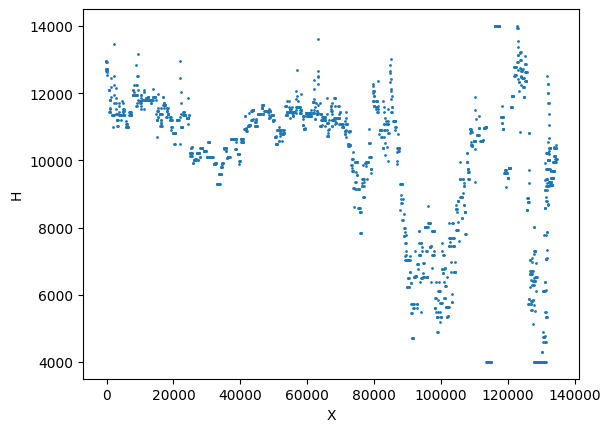

In [102]:
sample1.plot.scatter(x='X', y='H', s=1)

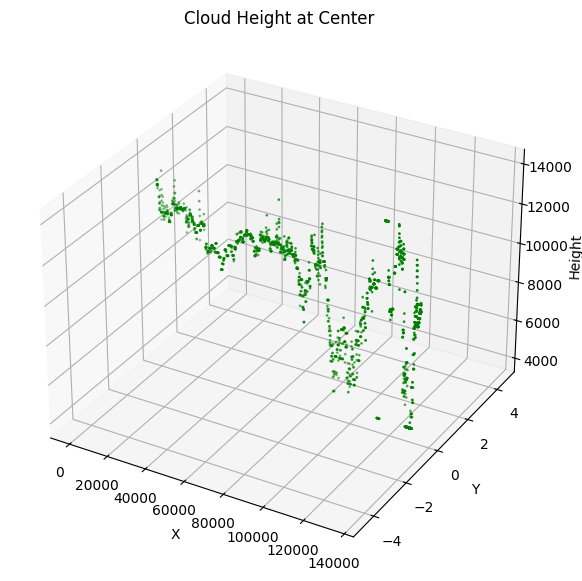

In [104]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(sample1["X"], sample1["Y"], sample1["H"], color = "green", s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Height')

plt.title("Cloud Height at Center")

ax.set_ylim3d(-5, 5)

# show plot
plt.show()

In [107]:
sample1 = df[(df["Y"]>=999.8)  & (df["Y"]<=1000.2)] # & (df["X"]>=20000)  & (df["X"]<=40000)
sample1.shape

(6927, 3)

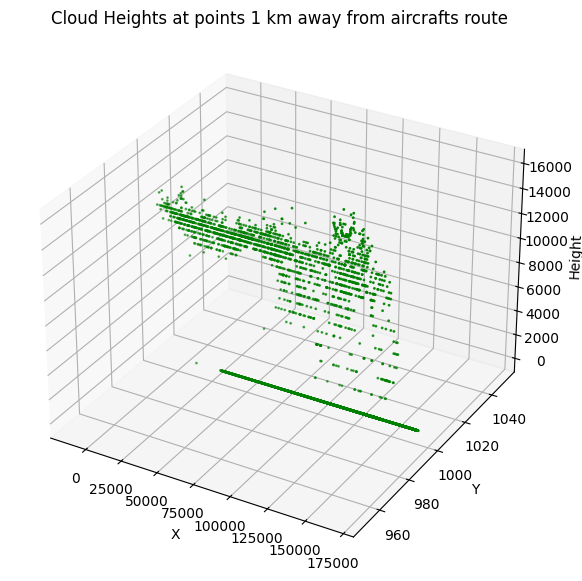

In [109]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(sample1["X"], sample1["Y"], sample1["H"], color = "green", s=1)
plt.title("Cloud Heights at points 1 km away from aircrafts route")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Height')

# show plot
plt.show()

In [94]:
sample1 = df[(df["X"]==10000)] # & (df["X"]>=20000)  & (df["X"]<=40000)
sample1.shape

(356, 3)

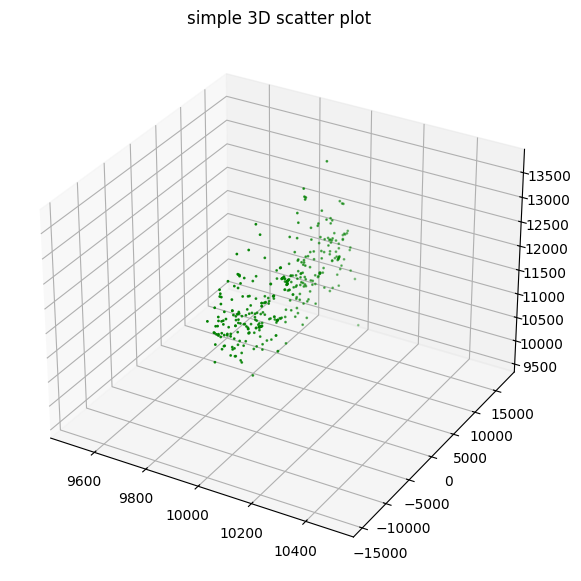

In [95]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(sample1["X"], sample1["Y"], sample1["H"], color = "green", s=1)
plt.title("simple 3D scatter plot")

#ax.set_ylim3d(999.8, 1000.2)
#ax.set_xlim3d(0, 12500)
#ax.set_zlim3d(2000, 14000)

# show plot
plt.show()